In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import yfinance as yf

In [2]:
conti_stocks_df = pd.read_csv(r"D:\streamlit_learn\streamlit_learn\conti.csv")
conti_stocks_df.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2015-09-04 00:00:00+02:00,130.363816,130.431868,125.940084,126.994972,584498,0.0,0.0
1,2015-09-07 00:00:00+02:00,128.560311,128.798516,126.892907,128.185989,217077,0.0,0.0
2,2015-09-08 00:00:00+02:00,128.934631,132.779875,128.866579,131.078445,568550,0.0,0.0
3,2015-09-09 00:00:00+02:00,135.093821,135.808414,132.065260,132.269440,516951,0.0,0.0
4,2015-09-10 00:00:00+02:00,130.976344,133.460441,130.670086,131.690948,360871,0.0,0.0


In [3]:
# Convert with timezone awareness
conti_stocks_df['Date'] = pd.to_datetime(conti_stocks_df['Date'], utc=True)

# Remove timestamp:
conti_stocks_df['Date'] = conti_stocks_df['Date'].dt.tz_localize(None)

# Now you can floor to day
conti_stocks_df['Date'] = conti_stocks_df['Date'].dt.floor('D')

conti_stocks_df.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2015-09-03,130.363816,130.431868,125.940084,126.994972,584498,0.0,0.0
1,2015-09-06,128.560311,128.798516,126.892907,128.185989,217077,0.0,0.0
2,2015-09-07,128.934631,132.779875,128.866579,131.078445,568550,0.0,0.0
3,2015-09-08,135.093821,135.808414,132.065260,132.269440,516951,0.0,0.0
4,2015-09-09,130.976344,133.460441,130.670086,131.690948,360871,0.0,0.0


In [4]:
conti_stocks_df_new = conti_stocks_df[['Date', 'Close', 'Open', 'High', 'Low', 'Volume']].copy()

In [5]:
train_size = int(len(conti_stocks_df_new) * 0.8)
train, test = conti_stocks_df_new.iloc[:train_size], conti_stocks_df_new.iloc[train_size:]

In [6]:
from statsmodels.tsa.statespace.structural import UnobservedComponents
model = UnobservedComponents(train['Close'], level='local linear trend')
fit_model = model.fit(disp=False)

In [10]:
forecast_mean = fit_model.forecast(steps=len(test))
forecast_series = pd.Series(forecast_mean.values, index=test['Date'])

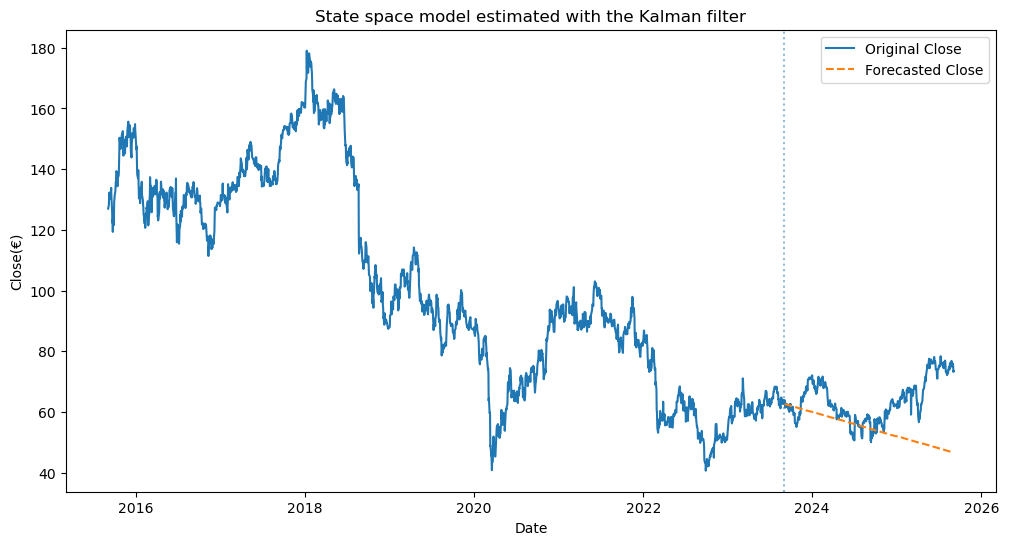

In [11]:
plt.figure(figsize=(12,6))
plt.plot(conti_stocks_df_new['Date'], conti_stocks_df_new['Close'], label="Original Close")
plt.plot(forecast_series.index, forecast_series, label="Forecasted Close", linestyle="--")
# Mark training end
plt.axvline(conti_stocks_df_new["Date"].iloc[train_size-1], alpha=0.5, linestyle=":")
plt.xlabel("Date")
plt.ylabel("Close(€)")
plt.title("State space model estimated with the Kalman filter")
plt.legend()
plt.show()

In [12]:
# Forecast for training (in-sample predictions)
train_pred = fit_model.predict(start=0, end=len(train)-1)

# Forecast for test set
test_forecast = fit_model.forecast(steps=len(test))

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
def calculate_metrics(actual, predicted, dataset_name=""):
    mae = mean_absolute_error(actual, predicted)
    mse = mean_squared_error(actual, predicted)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((actual - predicted) / actual)) * 100
    r2 = r2_score(actual, predicted)
    smape = 100 * np.mean(2 * np.abs(predicted - actual) / (np.abs(actual) + np.abs(predicted)))

    print(f"\nPerformance Metrics for {dataset_name}:")
    print(f"MAE  : {mae:.4f}")
    print(f"MSE  : {mse:.4f}")
    print(f"RMSE : {rmse:.4f}")
    print(f"MAPE : {mape:.2f}%")
    print(f"sMAPE : {smape:.2f}%")
    

# Training metrics
calculate_metrics(train['Close'], train_pred, "Training")

# Testing metrics
calculate_metrics(test['Close'], test_forecast, "Testing")


Performance Metrics for Training:
MAE  : 1.4700
MSE  : 11.7302
RMSE : 3.4249
MAPE : 1.58%
sMAPE : 1.62%

Performance Metrics for Testing:
MAE  : 10.0103
MSE  : 183.9184
RMSE : 13.5617
MAPE : 14.54%
sMAPE : 16.59%
